In [2]:
import pandas as pd
import glob
from numpy import float64 as f64
import matplotlib.pyplot as plt

SIZEOF_DOUBLE = 8

path = 'log/PAPER/NCU/NEW'
all_files = glob.glob(path + "/*.csv")


kernel_df_tuple_list = []

for filename in all_files:
    try:
        kernel_name = filename.split('/')[4].split('_')[1]
        impl        = filename.split('/')[4].split('_')[5].split('.')[0]
        ny          = filename.split('/')[4].split('_')[3].split('.')[0]
        nx          = filename.split('/')[4].split('_')[2].split('.')[0]
        print(filename.split('/')[4])

        m_tuple = (kernel_name, impl, nx, ny, 
                pd.read_csv(filename, skiprows=2)[['Metric Name', 'Metric Unit', 'Metric Value']])

        if(int(ny) == 2**14): kernel_df_tuple_list.append(m_tuple)
        # kernel_df_tuple_list.append(m_tuple)

    except Exception as ex:
        print(f"Error for file {filename.split('/')[4]}")
        print(ex)

# df = pd.read_csv("log/PAPER/NCU/...")[['Metric Name', 'Metric Unit', 'Metric Value']]

profadv_BasicRange2D_1024_16384_gpu_DPCPP.csv
profadv_NDRange_1024_16384_gpu_DPCPP.csv
profadv_Hierarchical_1024_16384_gpu_DPCPP.csv
profadv_BasicRange1D_1024_16384_gpu_ACPP.csv
profadv_Scoped_1024_16384_gpu_ACPP.csv
profadv_BasicRange1D_1024_16384_gpu_DPCPP.csv
profadv_NDRange_1024_16384_gpu_ACPP.csv
profadv_Hierarchical_1024_16384_gpu_ACPP.csv
profadv_BasicRange2D_1024_16384_gpu_ACPP.csv


In [3]:
def compute_total_dynamic_mem(
    shmem: f64,
    warp_occupancy: f64,
    block_size: int,
    # buffer_size: int,
    # avg=False,
):
    """Computes the total amount of memory used by dynamic work group
    allocations on a NVIDIA A100 GPU

    Args:
        shmem (np.float64): Amount of shared memory allocated, in bytes
        warp_occupancy (np.float64): Achieved warp occupancy for one Streaming Multiprocessor
        block_size (int): Size of CUDA block of the kernel
        buffer_size (int): Size of nx buffer

    Returns:
        _type_: _description_
    """
    NB_SM = 108     # A100 GPU has 108 SM
    WARP_SIZE = 32  # A single warp is composed of 32 threads

    # MAX_WARP_PER_SM = 36 # On 1 SM 36 warps can run

    n_warp_per_block = block_size / WARP_SIZE
    
    # if avg :
    n_blocks_per_sm = warp_occupancy / n_warp_per_block
    # else:
        # n_blocks_per_sm = MAX_WARP_PER_SM / n_warp_per_block

    # assert (
        # buffer_size * SIZEOF_DOUBLE == shmem
    # )  # shared memory should be equal to buffer_size*sizeof(double)

    return n_blocks_per_sm * NB_SM * shmem

In [4]:
def compute_theoretical_footprint(
    n_x :int,
    p_y :int):
    """Computes theoretical memory footprint

    Args:
        n_x (int): Size of allocated local_accessor
        p_y (int): Parallelism degree in y. If unknown, calculate with p/p_x.

    Returns:
        int: Memory footprint in bytes
    """

    return SIZEOF_DOUBLE * p_y * n_x

In [5]:
m_dict = {
    "id-impl":[],
    "impl":[],      # SYCL implementation
    "kernel":[],    # Kernel implementation name
    "nx":[],  #
    "ny":[],  #
    "block":[],     # Size of CUDA block
    "grid":[],      # Size of CUDA grid
    "regs":[],      # Registers Per Thread
    "shmemperB":[], # Dynamic Shared Memory Per Block (Bytes)
    "warpSM_avg":[],    # Achieved Active Warps Per SM
    "warpSM_peak":[],    # Theoretical peak warp per SM
    "avgshmem":[],  # Actual total memory footprint (computed with other values)
    "peakshmem":[], # Theoretical peak of shared memory used within the GPU
    "theorymem":[], # Theoretical memory footprint
    "buffermem":[], # Total memory used for the buffer
    "totalmem":[],  # Total memory footprint of the algorithm
}

GIGA = 10**9
MEGA = 10**6
KILO = 10**3

U = MEGA

for tup in kernel_df_tuple_list:
    kernel_name = tup[0]
    impl = tup[1]
    nx = int(tup[2])
    ny = int(tup[3])
    df = tup[4]
    
    b_size      = int(df[df['Metric Name'] == 'launch__block_size']                    ['Metric Value'].values[0])
    g_size      = int(df[df['Metric Name'] == 'launch__grid_size']                     ['Metric Value'].values[0])
    n_reg       = int(df[df['Metric Name'] == 'launch__registers_per_thread']          ['Metric Value'].values[0])
    shmem       = f64(df[df['Metric Name'] == 'launch__shared_mem_per_block_dynamic']  ['Metric Value'].values[0])
    warpSM_avg  = f64(df[df['Metric Name'] == 'sm__warps_active.avg.per_cycle_active'] ['Metric Value'].values[0])
    warpSM_peak = f64(df[df['Metric Name'] == 'sm__maximum_warps_avg_per_active_cycle']['Metric Value'].values[0])
    buffer_size = nx*ny*SIZEOF_DOUBLE
    
    avg_shmem   = compute_total_dynamic_mem(shmem, warpSM_avg, b_size)#, nx, avg=True)
    peak_shmem  = compute_total_dynamic_mem(shmem, warpSM_peak, b_size)#, nx, avg=False)
    
    totalmem = buffer_size+peak_shmem
    
    if not str(kernel_name).find("BasicRange") : totalmem += buffer_size
    
    p = 10**5 # Gpu parallelism degree (estimation)
    p_y = p / b_size # b_size is the parallelism in x
    theoretical_mem_fotprint = compute_theoretical_footprint(nx, p_y)
    
    
    m_dict["id-impl"]       .append(str(kernel_name+"-"+impl.lower()))
    m_dict["impl"]       .append(impl)
    m_dict["kernel"]     .append(kernel_name)
    m_dict["nx"]         .append(nx)
    m_dict["ny"]         .append(ny)
    m_dict["block"]      .append(b_size)
    m_dict["grid"]       .append(g_size)
    m_dict["regs"]       .append(n_reg)
    m_dict["shmemperB"]  .append(shmem)
    m_dict["warpSM_avg"] .append(warpSM_avg)
    m_dict["warpSM_peak"].append(warpSM_peak)
    m_dict["avgshmem"]   .append(avg_shmem/U)
    m_dict["peakshmem"]  .append(peak_shmem/U)
    m_dict["theorymem"]  .append(theoretical_mem_fotprint/U)
    m_dict["buffermem"]  .append(buffer_size/U)
    m_dict["totalmem"]   .append((totalmem-buffer_size)/U)

In [6]:
df_full = pd.DataFrame(m_dict).sort_values('kernel')
# df_full.to_latex("table.tex", float_format="%.2f")
df_full

,id-impl,impl,kernel,nx,ny,block,grid,regs,shmemperB,warpSM_avg,warpSM_peak,avgshmem,peakshmem,theorymem,buffermem,totalmem
3,BasicRange1D-acpp,ACPP,BasicRange1D,1024,16384,128,128,46,0.0,5.07,40.0,0.000000,0.000000,6.4,134.217728,134.217728
5,BasicRange1D-dpcpp,DPCPP,BasicRange1D,1024,16384,512,32,48,0.0,16.00,32.0,0.000000,0.000000,1.6,134.217728,134.217728
0,BasicRange2D-dpcpp,DPCPP,BasicRange2D,1024,16384,512,32768,50,0.0,28.62,32.0,0.000000,0.000000,1.6,134.217728,134.217728
8,BasicRange2D-acpp,ACPP,BasicRange2D,1024,16384,256,65536,46,0.0,36.79,40.0,0.000000,0.000000,3.2,134.217728,134.217728
2,Hierarchical-dpcpp,DPCPP,Hierarchical,1024,16384,128,16384,68,8192.0,27.39,28.0,6.058230,6.193152,6.4,134.217728,6.193152
7,Hierarchical-acpp,ACPP,Hierarchical,1024,16384,128,16384,56,8192.0,35.01,36.0,7.743652,7.962624,6.4,134.217728,7.962624
1,NDRange-dpcpp,DPCPP,NDRange,1024,16384,1024,16384,50,8192.0,31.34,32.0,0.866488,0.884736,0.8,134.217728,0.884736
6,NDRange-acpp,ACPP,NDRange,1024,16384,1024,16384,50,8192.0,31.25,32.0,0.864000,0.884736,0.8,134.217728,0.884736
4,Scoped-acpp,ACPP,Scoped,1024,16384,1024,16384,46,8192.0,31.73,32.0,0.877271,0.884736,0.8,134.217728,0.884736


In [7]:
df_full[
    [
        "impl",
        "kernel",
        "block",
        "grid",
        "shmemperB",
        "peakshmem",
        "theorymem",
        "totalmem",
        "regs",
    ]
].sort_values(["kernel", "impl"]).to_latex("table_CUDA.tex", float_format="%.2f")

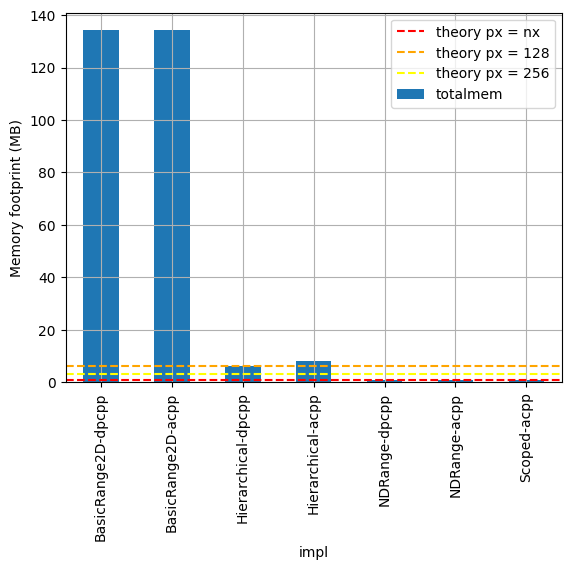

In [67]:
ax = df_full[
            #  (df_full["kernel"] != "BasicRange2D") &
            #  (df_full["kernel"] != "Hierarchical") &
             (df_full["kernel"] != "BasicRange1D")].plot.bar(
                x='id-impl',
                y='totalmem',
                xlabel='impl',
                ylabel='Memory footprint (MB)')

ax.grid()
ax.axhline(786432/U, ls='--', color='r', label="theory px = nx") # TODO add line with theoretical
ax.axhline(6291456/U, ls='--', color='orange', label="theory px = 128")
ax.axhline(3145728/U, ls='--', color='yellow', label="theory px = 256")
ax.legend()

# ROCPROF Values

In [24]:
# path = 'log/PAPER/ROCPROF/NEW/NEW/NEW'

path = 'log/PAPER/NEW_ROCPROF_TEST'
files = glob.glob(path + "/*.csv")

tuple_list = []

for full_filename in files:
    filename = full_filename.split('/')[-1]

    try:

        kernel_name = filename.split('_')[1]
        impl        = filename.split('_')[5].split('.')[0]
        ny          = filename.split('_')[3].split('.')[0]
        nx          = filename.split('_')[2].split('.')[0]

        m_tuple = (kernel_name, impl, nx, ny, 
                pd.read_csv(full_filename) )

        # if(int(ny) == 2**14):tuple_list.append(m_tuple)
        tuple_list.append(m_tuple)

    except Exception as ex:
        print(f"Error for file {filename}")
        print(ex)

# df = pd.read_csv("log/PAPER/NCU/...")[['Metric Name', 'Metric Unit', 'Metric Value']]

In [25]:
m_dict_rocm = {
    "id-impl":[],
    "impl":[],      # SYCL implementation
    "kernel":[],    # Kernel implementation name
    "nx":[],  #
    "ny":[],  #
    "block":[],     # Size of block
    "grid":[],      # Size of grid
    "lds":[], # Local Data Store for the kernel
    "scratch":[], # Scratch memory for the kernel
    "ldsInst":[], # LDS Read or LDS write instructions
    "SfetchInst":[], # The average number of scalar fetch instructions from the video memory executed per work-item (affected by flow control).

    "fetchSize":[], # Total kilobytes fetched from DRAM
    "writeSize":[], # Total kilobytes written to DRAM

    "arch_vgpr":[],
    "accum_vgpr":[],
    "sgpr":[],

    "peakshmem":[],
}

In [26]:
pd.set_option('display.max_columns', None)

- `MemUnitBusy` : The percentage of GPUTime the memory unit is active. The result includes the stall time (MemUnitStalled). This is measured with all extra fetches and writes and any cache or memory effects taken into account. Value range: 0% to 100% (fetch-bound).
- `TCC_MISS_sum` : Number of cache misses. UC reads count as misses. Sum over TCC instances.
- `TCC_HIT_sum` : Number of cache hits. Sum over TCC instances.
- `L2CacheHit` : The percentage of fetch, write, atomic, and other instructions that hit the data in L2 cache. Value range: 0% (no hit) to 100% (optimal).
- `VALUBusy` : The percentage of GPUTime vector ALU instructions are processed. Value range: 0% (bad) to 100% (optimal).
- `SFetchInsts` : The average number of scalar fetch instructions from the video memory executed per work-item (affected by flow control).
- `SALUInsts` : The average number of scalar ALU instructions executed per work-item (affected by flow control).
- `VALUInsts` : The average number of vector ALU instructions executed per work-item (affected by flow control).
- `LDSInsts` : The average number of LDS read or LDS write instructions executed per work item (affected by flow control).  Excludes FLAT instructions that read from or write to LDS.
- `FlatVMemInsts` : The average number of FLAT instructions that read from or write to the video memory executed per work item (affected by flow control). Includes FLAT instructions that read from or write to scratch.
- `MemUnitBusy` : The percentage of GPUTime the memory unit is active. The result includes the stall time (MemUnitStalled). This is measured with all extra fetches and writes and any cache or memory effects taken into account. Value range: 0% to 100% (fetch-bound).
- `FETCH_SIZE` : The total kilobytes fetched from the video memory. This is measured with all extra fetches and any cache or memory effects taken into account.
- `WRITE_SIZE` : The total kilobytes written to the video memory. This is measured with all extra fetches and any cache or memory effects taken into account.


- `wave_size` : taille du "warp"



<!-- Index - kernels dispatch order index -->
<!-- KernelName - kernel name -->
<!-- gpu-id - GPU ID the kernel was submitted to -->
<!-- queue-id - ROCm queue unique id the kernel was submitted to -->
<!-- queue-index - ROCm queue write index for the submitted AQL packet -->
<!-- tid - system application thread id that submitted the kernel -->


<!-- grd - kernel’s grid size -->
<!-- wgr - kernel’s work group size -->
<!-- lds - kernel’s LDS memory size -->
<!-- scr - kernel’s scratch memory size -->

vgpr - kernel’s VGPR size

sgpr - kernel’s SGPR size

fbar - kernel’s barriers limitation

sig - kernel’s completion signal


In [27]:
def compute_total_dynamic_mem_AMDGPU(
    shmem: f64,
    warp_occupancy: f64,
    block_size: int,
    ):
    
    NB_CU = 220/2 #we only use 1 GCD
    WAVEFRONT_SIZE = 64

    n_warp_per_block = block_size / WAVEFRONT_SIZE
    
    n_blocks_per_sm = warp_occupancy / n_warp_per_block

    return n_blocks_per_sm * NB_CU * shmem

In [28]:
for tup in tuple_list:
    kernel_name = tup[0]
    impl = tup[1]
    nx = int(tup[2])
    ny = int(tup[3])
    df = tup[4]
    
    
    display(df)
    
    # print(df['wgr'].values[0])
    b_size      = int(df['wgr'].values[0])
    g_size      = int(df['grd'].values[0])
    # n_reg       = int(df[df['Metric Name'] == 'launch__registers_per_thread']          ['Metric Value'].values[0])
    lds         = int(df['lds'].values[0])
    scratch     = int(df['scr'].values[0])
    ldsInst = f64(df['LDSInsts'].values[0])
    sFetchInst = f64(df['SFetchInsts'].values[0])
    
    fetchS = f64(df['FETCH_SIZE'].values[0]) #in KB
    writeS = f64(df['WRITE_SIZE'].values[0]) #in KB
    buffer_size = nx*ny*SIZEOF_DOUBLE


    WAVE_SIZE=64
    wavefront_per_cu = (b_size/64)*16


    warpSM_peak = wavefront_per_cu #TODO
    peak_shmem  = compute_total_dynamic_mem_AMDGPU(lds, warpSM_peak, b_size)#, nx, avg=False)
    
    totalmem = buffer_size+peak_shmem
    
    # if not str(kernel_name).find("BasicRange") : totalmem += buffer_size
    
    p = 10**5 # Gpu parallelism degree (estimation)
    p_y = p / b_size # b_size is the parallelism in x
    theoretical_mem_fotprint = compute_theoretical_footprint(nx, p_y)


    
    m_dict_rocm["id-impl"]       .append(str(kernel_name+"-"+impl.lower()))
    m_dict_rocm["impl"]       .append(impl)
    m_dict_rocm["kernel"]     .append(kernel_name)
    m_dict_rocm["nx"]         .append(nx)
    m_dict_rocm["ny"]         .append(ny)
    m_dict_rocm["block"]      .append(b_size)
    m_dict_rocm["grid"]       .append(g_size)

    m_dict_rocm["lds"]      .append(lds)
    m_dict_rocm["ldsInst"]  .append(ldsInst)

    m_dict_rocm["scratch"]   .append(scratch)
    m_dict_rocm["SfetchInst"].append(sFetchInst)
    
    m_dict_rocm["fetchSize"] .append(fetchS)
    m_dict_rocm["writeSize"] .append(writeS)

    m_dict_rocm["arch_vgpr"] .append(int(df['arch_vgpr'].values[0]))
    m_dict_rocm["accum_vgpr"].append(int(df['accum_vgpr'].values[0]))
    m_dict_rocm["sgpr"]      .append(int(df['sgpr'].values[0]))
    
    m_dict_rocm["peakshmem"]  .append(peak_shmem/U)

    # m_dict_rocm["theorymem"]  .append(theoretical_mem_fotprint/U)
    # m_dict_rocm["buffermem"]  .append(buffer_size/U)
    # m_dict_rocm["totalmem"]   .append(totalmem/U)
    
    # m_dict_rocm["TMP_VALUE"].append(df['TA'])

,Index,KernelName,gpu-id,queue-id,queue-index,pid,tid,grd,wgr,lds,scr,arch_vgpr,accum_vgpr,sgpr,wave_size,sig,obj,FETCH_SIZE,WRITE_SIZE,MemUnitBusy,FlatVMemInsts,LDSInsts,VALUInsts,SALUInsts,SFetchInsts,VALUBusy,L2CacheHit,TCC_HIT_sum,TCC_MISS_sum,TA_TOTAL_WAVEFRONTS_sum,TA_BUFFER_WAVEFRONTS_sum
0,1,typeinfo name for AdvX::BasicRange2D::operator...,0,2,0,167873,167873,16777216,1024,0,128,36,4,48,64,0x0,0x14dfc9dd33c0,131136.4375,356909.625,58.784279,13.0,0.0,299.0,90.0,10.0,47.336221,89.813063,22585122.0,2557518.0,4194304.0,786432.0


,Index,KernelName,gpu-id,queue-id,queue-index,pid,tid,grd,wgr,lds,scr,arch_vgpr,accum_vgpr,sgpr,wave_size,sig,obj,FETCH_SIZE,WRITE_SIZE,MemUnitBusy,FlatVMemInsts,LDSInsts,VALUInsts,SALUInsts,SFetchInsts,VALUBusy,L2CacheHit,TCC_HIT_sum,TCC_MISS_sum,TA_TOTAL_WAVEFRONTS_sum,TA_BUFFER_WAVEFRONTS_sum
0,1,void __hipsycl_kernel<AdvX::BasicRange1D::oper...,0,3,2,2773779,2773790,65536,128,0,0,48,0,80,64,0x0,0x14868b108e40,2.442324e+07,1.318460e+07,99.224664,13312.0,0.0,266266.300781,48155.976562,10.0,1.142969,9.510897,82588136.0,786710469.0,13631488.0,0.0


,Index,KernelName,gpu-id,queue-id,queue-index,pid,tid,grd,wgr,lds,scr,arch_vgpr,accum_vgpr,sgpr,wave_size,sig,obj,FETCH_SIZE,WRITE_SIZE,MemUnitBusy,FlatVMemInsts,LDSInsts,VALUInsts,SALUInsts,SFetchInsts,VALUBusy,L2CacheHit,TCC_HIT_sum,TCC_MISS_sum,TA_TOTAL_WAVEFRONTS_sum,TA_BUFFER_WAVEFRONTS_sum
0,1,typeinfo name for AdvX::NDRange::operator()(sy...,0,2,0,1166197,1166197,16777216,1024,8192,16,44,4,32,64,0x0,0x148a17fc8f40,131089.5625,270560.875,41.307962,7.0,2.0,294.0,76.0,11.0,57.162173,82.675671,5374494.0,1123813.0,2621440.0,786432.0


,Index,KernelName,gpu-id,queue-id,queue-index,pid,tid,grd,wgr,lds,scr,arch_vgpr,accum_vgpr,sgpr,wave_size,sig,obj,FETCH_SIZE,WRITE_SIZE,MemUnitBusy,FlatVMemInsts,LDSInsts,VALUInsts,SALUInsts,SFetchInsts,VALUBusy,L2CacheHit,TCC_HIT_sum,TCC_MISS_sum,TA_TOTAL_WAVEFRONTS_sum,TA_BUFFER_WAVEFRONTS_sum
0,1,typeinfo name for AdvX::Hierarchical::operator...,0,2,0,738972,738972,4194304,256,8704,48,88,0,80,64,0x0,0x14d1767d8f40,138161.875,430968.59375,46.232589,30.0,45.75,1158.5,224.25,11.25,47.496626,67.823123,6107391.0,2892824.0,3604480.0,1638400.0


,Index,KernelName,gpu-id,queue-id,queue-index,pid,tid,grd,wgr,lds,scr,arch_vgpr,accum_vgpr,sgpr,wave_size,sig,obj,FETCH_SIZE,WRITE_SIZE,MemUnitBusy,FlatVMemInsts,LDSInsts,VALUInsts,SALUInsts,SFetchInsts,VALUBusy,L2CacheHit,TCC_HIT_sum,TCC_MISS_sum,TA_TOTAL_WAVEFRONTS_sum,TA_BUFFER_WAVEFRONTS_sum
0,1,void __hipsycl_kernel<hipsycl::glue::multivers...,0,3,2,3742740,3742752,67108864,1024,8192,0,44,4,48,64,0x0,0x147f799d2900,524295.0625,520192.0,65.407021,7.0,2.0,296.0,85.0,8.0,98.541299,68.484756,9113333.0,4194395.0,7340032.0,0.0


,Index,KernelName,gpu-id,queue-id,queue-index,pid,tid,grd,wgr,lds,scr,arch_vgpr,accum_vgpr,sgpr,wave_size,sig,obj,FETCH_SIZE,WRITE_SIZE,MemUnitBusy,FlatVMemInsts,LDSInsts,VALUInsts,SALUInsts,SFetchInsts,VALUBusy,L2CacheHit,TCC_HIT_sum,TCC_MISS_sum,TA_TOTAL_WAVEFRONTS_sum,TA_BUFFER_WAVEFRONTS_sum
0,1,void __hipsycl_kernel<AdvX::BasicRange1D::oper...,0,3,2,367438,367449,16384,128,0,0,48,0,80,64,0x0,0x14ac14508e40,152185.4375,1.372694e+06,60.957795,13312.0,0.0,266266.300781,48155.976562,10.0,3.284547,98.82155,215208141.0,2562498.0,3407872.0,0.0


,Index,KernelName,gpu-id,queue-id,queue-index,pid,tid,grd,wgr,lds,scr,arch_vgpr,accum_vgpr,sgpr,wave_size,sig,obj,FETCH_SIZE,WRITE_SIZE,MemUnitBusy,FlatVMemInsts,LDSInsts,VALUInsts,SALUInsts,SFetchInsts,VALUBusy,L2CacheHit,TCC_HIT_sum,TCC_MISS_sum,TA_TOTAL_WAVEFRONTS_sum,TA_BUFFER_WAVEFRONTS_sum
0,1,void __hipsycl_kernel<hipsycl::glue::multivers...,0,3,2,1166655,1166668,16777216,1024,8192,0,44,4,48,64,0x0,0x14b567572900,131079.0625,126976.0,64.341698,7.0,2.0,296.0,85.0,8.0,97.136675,68.490588,2279032.0,1048666.0,1835008.0,0.0


,Index,KernelName,gpu-id,queue-id,queue-index,pid,tid,grd,wgr,lds,scr,arch_vgpr,accum_vgpr,sgpr,wave_size,sig,obj,FETCH_SIZE,WRITE_SIZE,MemUnitBusy,FlatVMemInsts,LDSInsts,VALUInsts,SALUInsts,SFetchInsts,VALUBusy,L2CacheHit,TCC_HIT_sum,TCC_MISS_sum,TA_TOTAL_WAVEFRONTS_sum,TA_BUFFER_WAVEFRONTS_sum
0,1,typeinfo name for AdvX::NDRange::operator()(sy...,0,2,0,3742273,3742273,67108864,1024,8192,16,44,4,32,64,0x0,0x14b2889d8f40,524307.5625,1095887.25,59.89141,7.0,2.0,294.0,76.0,11.0,83.450113,82.887653,21547587.0,4440978.0,10485760.0,3145728.0


,Index,KernelName,gpu-id,queue-id,queue-index,pid,tid,grd,wgr,lds,scr,arch_vgpr,accum_vgpr,sgpr,wave_size,sig,obj,FETCH_SIZE,WRITE_SIZE,MemUnitBusy,FlatVMemInsts,LDSInsts,VALUInsts,SALUInsts,SFetchInsts,VALUBusy,L2CacheHit,TCC_HIT_sum,TCC_MISS_sum,TA_TOTAL_WAVEFRONTS_sum,TA_BUFFER_WAVEFRONTS_sum
0,1,typeinfo name for AdvX::Hierarchical::operator...,0,2,0,1100451,1100451,16777216,256,8704,48,88,0,80,64,0x0,0x14e3d6158f40,552727.5625,1.737805e+06,63.988031,30.0,45.75,1158.5,224.25,11.25,65.759406,67.673017,24380987.0,11601700.0,14417920.0,6553600.0


,Index,KernelName,gpu-id,queue-id,queue-index,pid,tid,grd,wgr,lds,scr,arch_vgpr,accum_vgpr,sgpr,wave_size,sig,obj,FETCH_SIZE,WRITE_SIZE,MemUnitBusy,FlatVMemInsts,LDSInsts,VALUInsts,SALUInsts,SFetchInsts,VALUBusy,L2CacheHit,TCC_HIT_sum,TCC_MISS_sum,TA_TOTAL_WAVEFRONTS_sum,TA_BUFFER_WAVEFRONTS_sum
0,1,typeinfo name for AdvX::BasicRange1D::operator...,0,2,0,366962,366962,16384,1024,0,16,48,0,64,64,0x0,0x146c500b1e80,154209.0625,1.387259e+06,32.960339,4437.333333,0.0,89497.433594,16321.492188,34.0,1.3567,98.864474,214693634.0,2469749.0,3433472.0,25600.0


,Index,KernelName,gpu-id,queue-id,queue-index,pid,tid,grd,wgr,lds,scr,arch_vgpr,accum_vgpr,sgpr,wave_size,sig,obj,FETCH_SIZE,WRITE_SIZE,MemUnitBusy,FlatVMemInsts,LDSInsts,VALUInsts,SALUInsts,SFetchInsts,VALUBusy,L2CacheHit,TCC_HIT_sum,TCC_MISS_sum,TA_TOTAL_WAVEFRONTS_sum,TA_BUFFER_WAVEFRONTS_sum
0,1,void __hipsycl_kernel<AdvX::NDRange::operator(...,0,3,2,545075,545092,16777216,1024,8192,0,44,4,32,64,0x0,0x14ccd45c8e00,131078.9375,126976.0,64.907602,7.0,2.0,289.0,57.0,8.0,97.711263,68.423674,2272371.0,1048665.0,1835008.0,0.0


,Index,KernelName,gpu-id,queue-id,queue-index,pid,tid,grd,wgr,lds,scr,arch_vgpr,accum_vgpr,sgpr,wave_size,sig,obj,FETCH_SIZE,WRITE_SIZE,MemUnitBusy,FlatVMemInsts,LDSInsts,VALUInsts,SALUInsts,SFetchInsts,VALUBusy,L2CacheHit,TCC_HIT_sum,TCC_MISS_sum,TA_TOTAL_WAVEFRONTS_sum,TA_BUFFER_WAVEFRONTS_sum
0,1,void __hipsycl_kernel<AdvX::Hierarchical::oper...,0,3,2,739485,739513,4194304,256,8192,0,56,0,64,64,0x0,0x14f7c03c8e00,131094.3125,126976.0,62.433838,28.0,8.0,1121.0,233.0,9.0,93.377223,69.20432,2360860.0,1050162.0,1835008.0,0.0


,Index,KernelName,gpu-id,queue-id,queue-index,pid,tid,grd,wgr,lds,scr,arch_vgpr,accum_vgpr,sgpr,wave_size,sig,obj,FETCH_SIZE,WRITE_SIZE,MemUnitBusy,FlatVMemInsts,LDSInsts,VALUInsts,SALUInsts,SFetchInsts,VALUBusy,L2CacheHit,TCC_HIT_sum,TCC_MISS_sum,TA_TOTAL_WAVEFRONTS_sum,TA_BUFFER_WAVEFRONTS_sum
0,1,void __hipsycl_kernel<AdvX::Hierarchical::oper...,0,3,2,1100950,1100971,16777216,256,8192,0,56,0,64,64,0x0,0x151cf7108e00,524330.375,520192.0,67.558137,28.0,8.0,1121.0,233.0,9.0,99.085846,69.208569,9438559.0,4199254.0,7340032.0,0.0


,Index,KernelName,gpu-id,queue-id,queue-index,pid,tid,grd,wgr,lds,scr,arch_vgpr,accum_vgpr,sgpr,wave_size,sig,obj,FETCH_SIZE,WRITE_SIZE,MemUnitBusy,FlatVMemInsts,LDSInsts,VALUInsts,SALUInsts,SFetchInsts,VALUBusy,L2CacheHit,TCC_HIT_sum,TCC_MISS_sum,TA_TOTAL_WAVEFRONTS_sum,TA_BUFFER_WAVEFRONTS_sum
0,1,void __hipsycl_kernel<AdvX::BasicRange2D::oper...,0,3,2,2557762,2557775,67108864,256,0,0,36,4,64,64,0x0,0x14a9865c8e40,524322.25,653429.125,97.198601,13.0,0.0,297.0,75.0,11.0,70.308669,91.825802,94273541.0,8389370.0,13631488.0,0.0


,Index,KernelName,gpu-id,queue-id,queue-index,pid,tid,grd,wgr,lds,scr,arch_vgpr,accum_vgpr,sgpr,wave_size,sig,obj,FETCH_SIZE,WRITE_SIZE,MemUnitBusy,FlatVMemInsts,LDSInsts,VALUInsts,SALUInsts,SFetchInsts,VALUBusy,L2CacheHit,TCC_HIT_sum,TCC_MISS_sum,TA_TOTAL_WAVEFRONTS_sum,TA_BUFFER_WAVEFRONTS_sum
0,1,void __hipsycl_kernel<AdvX::BasicRange2D::oper...,0,3,2,168396,168411,16777216,256,0,0,36,4,64,64,0x0,0x14af461d8e40,131091.5,155931.75,95.768302,13.0,0.0,297.0,75.0,11.0,69.987179,91.819788,23539463.0,2097500.0,3407872.0,0.0


,Index,KernelName,gpu-id,queue-id,queue-index,pid,tid,grd,wgr,lds,scr,arch_vgpr,accum_vgpr,sgpr,wave_size,sig,obj,FETCH_SIZE,WRITE_SIZE,MemUnitBusy,FlatVMemInsts,LDSInsts,VALUInsts,SALUInsts,SFetchInsts,VALUBusy,L2CacheHit,TCC_HIT_sum,TCC_MISS_sum,TA_TOTAL_WAVEFRONTS_sum,TA_BUFFER_WAVEFRONTS_sum
0,1,typeinfo name for AdvX::BasicRange2D::operator...,0,2,0,2557293,2557293,67108864,1024,0,128,36,4,48,64,0x0,0x154eb6bd33c0,524478.0,1412686.0,78.575319,13.0,0.0,299.0,90.0,10.0,64.266755,89.869209,90512854.0,10197812.0,16777216.0,3145728.0


,Index,KernelName,gpu-id,queue-id,queue-index,pid,tid,grd,wgr,lds,scr,arch_vgpr,accum_vgpr,sgpr,wave_size,sig,obj,FETCH_SIZE,WRITE_SIZE,MemUnitBusy,FlatVMemInsts,LDSInsts,VALUInsts,SALUInsts,SFetchInsts,VALUBusy,L2CacheHit,TCC_HIT_sum,TCC_MISS_sum,TA_TOTAL_WAVEFRONTS_sum,TA_BUFFER_WAVEFRONTS_sum
0,1,void __hipsycl_kernel<AdvX::NDRange::operator(...,0,3,2,796124,796141,67108864,1024,8192,0,44,4,32,64,0x0,0x14df1bf50e00,524294.9375,520192.0,66.174923,7.0,2.0,289.0,57.0,8.0,98.98896,68.398874,9078751.0,4194392.0,7340032.0,0.0


,Index,KernelName,gpu-id,queue-id,queue-index,pid,tid,grd,wgr,lds,scr,arch_vgpr,accum_vgpr,sgpr,wave_size,sig,obj,FETCH_SIZE,WRITE_SIZE,MemUnitBusy,FlatVMemInsts,LDSInsts,VALUInsts,SALUInsts,SFetchInsts,VALUBusy,L2CacheHit,TCC_HIT_sum,TCC_MISS_sum,TA_TOTAL_WAVEFRONTS_sum,TA_BUFFER_WAVEFRONTS_sum
0,1,typeinfo name for AdvX::BasicRange1D::operator...,0,2,0,2773310,2773310,65536,1024,0,16,48,0,64,64,0x0,0x14b904149e80,1.799366e+07,1.302938e+07,73.115734,13312.0,0.0,268316.300781,48169.976562,10.0,1.173453,34.586241,300608856.0,568643106.0,13733888.0,102400.0


In [14]:
rocm_df = pd.DataFrame(m_dict_rocm)
display((rocm_df[rocm_df['ny']==2**14]).sort_values(['kernel', 'impl']))
# (rocm_df[rocm_df['ny']==2**14]).to_latex("table2.tex", float_format="%.2f")

,id-impl,impl,kernel,nx,ny,block,grid,lds,scratch,ldsInst,SfetchInst,fetchSize,writeSize,arch_vgpr,accum_vgpr,sgpr,peakshmem
5,BasicRange1D-acpp,ACPP,BasicRange1D,1024,16384,128,16384,0,0,0.00,10.00,152185.4375,1.372694e+06,48,0,80,0.00000
9,BasicRange1D-dpcpp,DPCPP,BasicRange1D,1024,16384,1024,16384,0,16,0.00,34.00,154209.0625,1.387259e+06,48,0,64,0.00000
14,BasicRange2D-acpp,ACPP,BasicRange2D,1024,16384,256,16777216,0,0,0.00,11.00,131091.5000,1.559318e+05,36,4,64,0.00000
0,BasicRange2D-dpcpp,DPCPP,BasicRange2D,1024,16384,1024,16777216,0,128,0.00,10.00,131136.4375,3.569096e+05,36,4,48,0.00000
11,Hierarchical-acpp,ACPP,Hierarchical,1024,16384,256,4194304,8192,0,8.00,9.00,131094.3125,1.269760e+05,56,0,64,14.41792
3,Hierarchical-dpcpp,DPCPP,Hierarchical,1024,16384,256,4194304,8704,48,45.75,11.25,138161.8750,4.309686e+05,88,0,80,15.31904
10,NDRange-acpp,ACPP,NDRange,1024,16384,1024,16777216,8192,0,2.00,8.00,131078.9375,1.269760e+05,44,4,32,14.41792
2,NDRange-dpcpp,DPCPP,NDRange,1024,16384,1024,16777216,8192,16,2.00,11.00,131089.5625,2.705609e+05,44,4,32,14.41792
6,Scoped-acpp,ACPP,Scoped,1024,16384,1024,16777216,8192,0,2.00,8.00,131079.0625,1.269760e+05,44,4,48,14.41792


In [15]:
(rocm_df[rocm_df['ny']==2**16])[['impl', 'kernel', 'block', 'grid', 'lds', 'scratch', 'arch_vgpr', 'accum_vgpr', 'sgpr']].sort_values(['kernel', 'impl']).to_latex("table_AMD.tex", float_format="%.2f")


In [61]:
from math import floor
# def floor(a):return a

WF_PER_CU_MAX=40
WF_SIZE=64

VGPR_PER_WI_MAX=256
SGPR_PER_WI_MAX=102
SIMD_PER_CU=4

LDS_MAX=64000#Bytes

def compute_wf_lds(lds_used_in_bytes, wg_size):
    wg_max_lds = floor(LDS_MAX/lds_used_in_bytes)
    
    wf_wg = wg_size/WF_SIZE
    return wg_max_lds*wf_wg

def compute_wf_sgpr(sgpr_used, wg_size):
    wf_wg = wg_size/WF_SIZE

    a = min(floor(SGPR_PER_WI_MAX/sgpr_used)*SIMD_PER_CU, WF_PER_CU_MAX)/wf_wg
    return floor(a) * wf_wg

def compute_wf_vgpr(vgpr_used, wg_size):
    a = floor(VGPR_PER_WI_MAX/vgpr_used)
    # print(a)

    wf_vgpr = min(a* SIMD_PER_CU, WF_PER_CU_MAX)
    
    wf_wg = wg_size/WF_SIZE
    return floor(wf_vgpr/wf_wg) * wf_wg


def compute_wf_wg(size_wg):
    wf_per_wg = size_wg / WF_SIZE
    return min(16 * wf_per_wg, WF_PER_CU_MAX)

def compute_occupancy(wf_lds, wf_sgpr, wf_vgpr, wf_wg, wf_max = WF_PER_CU_MAX):
    return min(wf_lds, wf_sgpr, wf_vgpr, wf_wg)


def compute_all(wg_size, lds_used, sgpr_used, vgpr_used):

    wf_wg_limit = compute_wf_wg(wg_size)
    print(f"compute_wf_wg(wg_size) = {wf_wg_limit}")

    lds_limit = compute_wf_lds(lds_used, wg_size)
    print(f"compute_wf_lds(lds_used, wf_wg_limit) = {lds_limit}")
    
    sgpr_limit = compute_wf_sgpr(sgpr_used, wg_size)
    print(f"compute_wf_sgpr(sgpr_used, wf_wg_limit) = {sgpr_limit}")
    
    vgpr_limit = compute_wf_vgpr(vgpr_used, wg_size)
    print(f"compute_wf_vgpr(vgpr_used, wf_wg_limit) = {vgpr_limit}")
    
    return (compute_occupancy(lds_limit,
                             sgpr_limit,
                             vgpr_limit,
                             wf_wg_limit)) #* 110 * lds_used
                            #  wf_wg_limit) / (wg_size/WF_SIZE)) * 110 * lds_used
    

In [62]:
36	

36

In [66]:
# t1= wf_wg_limit = compute_wf_wg(256)
# print((compute_all(256, 8192, 64, 56)/t1) * 110 * 8192)
print(compute_all(256, 8192, 64, 56))


print(compute_all(1024, 8192, 32, 44))


print(compute_all(1024, 1, 64, 48))

compute_wf_wg(wg_size) = 40
compute_wf_lds(lds_used, wf_wg_limit) = 28.0
compute_wf_sgpr(sgpr_used, wf_wg_limit) = 4.0
compute_wf_vgpr(vgpr_used, wf_wg_limit) = 16.0
4.0
compute_wf_wg(wg_size) = 40
compute_wf_lds(lds_used, wf_wg_limit) = 112.0
compute_wf_sgpr(sgpr_used, wf_wg_limit) = 0.0
compute_wf_vgpr(vgpr_used, wf_wg_limit) = 16.0
0.0
compute_wf_wg(wg_size) = 40
compute_wf_lds(lds_used, wf_wg_limit) = 1024000.0
compute_wf_sgpr(sgpr_used, wf_wg_limit) = 0.0
compute_wf_vgpr(vgpr_used, wf_wg_limit) = 16.0
0.0
